In [1]:
from fastai.vision.all import *
import pandas as pd
import os
import random


In [2]:
code_path = os.getcwd()
crop_dataset = Path(code_path + "/resize")


def crop_get_label(fn):
    """
    Given a path to an image file, returns the path to the mask.
    """
    label_name = crop_dataset / "masks" / f"{fn.stem}_mask.png"
    return [label_name]


crop_all_images = [f for f in (crop_dataset / "images").glob("*")]
crop_all_masks = [crop_get_label(f) for f in crop_all_images]

crop_df = pd.DataFrame(
    {
        "dataset": ["crop"] * len(crop_all_images),
        "image": crop_all_images,
        "mask": crop_all_masks,
    }
)
crop_df


,dataset,image,mask
0,crop,/extra/code/bus/resize/images/i06.png,[/extra/code/bus/resize/masks/i06_mask.png]
1,crop,/extra/code/bus/resize/images/i00.png,[/extra/code/bus/resize/masks/i00_mask.png]
2,crop,/extra/code/bus/resize/images/i02.png,[/extra/code/bus/resize/masks/i02_mask.png]
3,crop,/extra/code/bus/resize/images/i07.png,[/extra/code/bus/resize/masks/i07_mask.png]
4,crop,/extra/code/bus/resize/images/i03.png,[/extra/code/bus/resize/masks/i03_mask.png]
5,crop,/extra/code/bus/resize/images/i09.png,[/extra/code/bus/resize/masks/i09_mask.png]
6,crop,/extra/code/bus/resize/images/i04.png,[/extra/code/bus/resize/masks/i04_mask.png]
7,crop,/extra/code/bus/resize/images/i05.png,[/extra/code/bus/resize/masks/i05_mask.png]
8,crop,/extra/code/bus/resize/images/i01.png,[/extra/code/bus/resize/masks/i01_mask.png]
9,crop,/extra/code/bus/resize/images/i08.png,[/extra/code/bus/resize/masks/i08_mask.png]


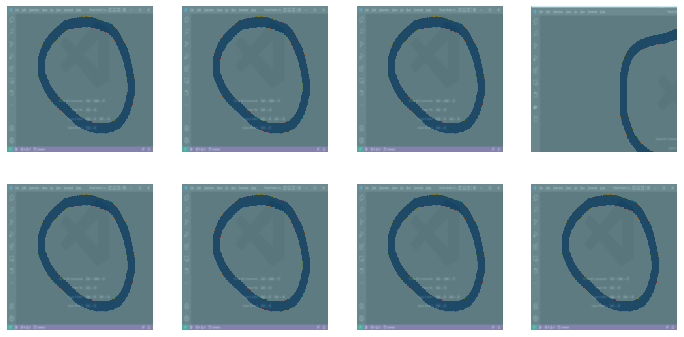

In [3]:
def make_mask(row):
    """
    Is called by DataBlock(getters=).
    Takes a list of paths to mask files from a Pandas column.
    Makes sure all masks are 8 bits per pixel.
    If there are multiple masks, merges them.
    Returns a PILMask.create() mask image.
    """
    f = ColReader("mask")
    # PILMask.create() probably forces 8 bits per pixel.
    all_images = [np.asarray(PILMask.create(x)) for x in f(row)]
    image_stack = np.stack(all_images)
    image_union = np.amax(image_stack, axis=0)
    return PILMask.create(image_union)


def make_image(row):
    """
    Receives a Pandas row. Gets an image path from the "image" column.
    Makes sure all images are 8 bits per color channel.
    (There may be multiple color channels.)
    Returns a PILImage.create() image.
    """
    f = ColReader("image")
    # PILImage.create() probably forces 8 bits per color channel.
    image_array = np.asarray(PILImage.create(f(row)))
    return PILImage.create(image_array)


class CropBoxTransform(DisplayedTransform):
    def __init__(self, shape):
        self.shape = shape

    def encodes(self, x):
        return x.crop(self.shape)


# Most images are 960 x 720. A few images are much larger. So we resize to 960 x 720 first.
# The final resize is to the desired image size for the model.
crop_datablock = DataBlock(
    blocks=(ImageBlock, MaskBlock),
    getters=[make_image, make_mask],
    splitter=TrainTestSplitter(stratify=crop_df["dataset"].to_list()),
    item_tfms=[
        Resize(size=(960, 720), method="squish"),
        CropBoxTransform((0, 0, 960, 720)),
        Resize(size=224, method="squish"),
    ],
    batch_tfms=None,
)

crop_dataloader = crop_datablock.dataloaders(crop_df, bs=8)
crop_dataloader.show_batch()
